In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## Data Loader

In [2]:
df_ny = pd.read_csv('../data/processed/ny.csv')
df_aus = pd.read_csv('../data/processed/austin.csv')

# Add the city name as a new column in each DataFrame
df_ny['city'] = 'New York'
df_aus['city'] = 'Austin'

# Append the DataFrames
df = pd.concat([df_ny, df_aus], ignore_index=True)

df.drop('date.1',axis=1,inplace=True)
# Display the combined DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26200 entries, 0 to 26199
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          26200 non-null  object 
 1   grid          26200 non-null  float64
 2   bathroom      26200 non-null  float64
 3   bedroom       26200 non-null  float64
 4   car           26200 non-null  float64
 5   diningroom    26200 non-null  float64
 6   livingroom    26200 non-null  float64
 7   office        26200 non-null  float64
 8   utilityroom   26200 non-null  float64
 9   waterheater   26200 non-null  float64
 10  aircomp       26200 non-null  float64
 11  kitchenArea   26200 non-null  float64
 12  washer_dryer  26200 non-null  float64
 13  other         26200 non-null  float64
 14  day           26200 non-null  object 
 15  month         26200 non-null  object 
 16  day_name      26200 non-null  object 
 17  hour          26200 non-null  int64  
 18  minute        26200 non-nu

## Fix Data Types

In [3]:
# Define a function to convert data types
def convert_data_types(df):
    # Convert 'date' column to datetime if it exists
    if 'date' in df.columns and df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        
    if 'day' in df.columns and df['day'].dtype == 'object':
        df['day'] = pd.to_datetime(df['day'], errors='coerce')
    
    # Convert all other object columns to categorical
    for column in df.select_dtypes(include='object').columns:
        df[column] = df[column].astype('category')
    
    return df

# Define the correct order for months and days
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_of_day_order = ['Night', 'Morning', 'Afternoon', 'Evening']

# Define a function to convert data types and set categorical order
def convert_and_order_categories(df):
    # Convert 'date' column to datetime if it exists
    if 'date' in df.columns and df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Convert categorical columns with explicit ordering
    if 'month' in df.columns:
        df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
    if 'day_name' in df.columns:
        df['day_name'] = pd.Categorical(df['day_name'], categories=day_order, ordered=True)
    if 'time_of_day' in df.columns:
        df['time_of_day'] = pd.Categorical(df['time_of_day'], categories=time_of_day_order, ordered=True)
    
    # Convert remaining object columns to category without specific ordering
    for column in df.select_dtypes(include='object').columns:
        if column not in ['month', 'day_name', 'time_of_day']:  # Exclude already converted columns
            df[column] = df[column].astype('category')
    
    return df



In [4]:
# Apply the function to both DataFrames
df = convert_data_types(df)

df = convert_and_order_categories(df)


# ML Prediction

### Individal Model

In [14]:
# Global settings
max_iter = 10  # Maximum number of iterations for RandomizedSearchCV
cv_folds = 5  # Number of cross-validation folds

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define MAPE scorer for RandomizedSearchCV
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Function to plot actual vs predicted values for both train and test sets
def plot_train_vs_test(y_train, y_train_pred, y_test, y_test_pred, model_name):
    plt.figure(figsize=(12, 6))

    # Plot for training set
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5, color="blue", label="Predicted vs Actual")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color="red", linestyle="--", label="Perfect Fit (y=x)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Train: Actual vs Predicted ({model_name})")
    plt.legend()

    # Plot for test set
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5, color="green", label="Predicted vs Actual")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Perfect Fit (y=x)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Test: Actual vs Predicted ({model_name})")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to prepare the data with preprocessing (OneHotEncoding, Scaling)
def prepare_data(df, target_column, feature_columns=None):
    # Prepare the features (X) and target (y)
    X = df[feature_columns]
    y = df[target_column].values

    # Define categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

    # Create a preprocessor pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),   # Scale numerical features
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)   # One-hot encode categorical features, ignoring unknown categories
        ]
    )

    # Apply transformations to the features
    X_preprocessed = preprocessor.fit_transform(X)

    # Split the data randomly into train (80%) and test (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

    return X_train, y_train, X_test, y_test

# Function to evaluate models using RandomizedSearchCV for hyperparameter optimization
def evaluate_models(X_train, y_train, X_test, y_test):
    # Initialize base regression models and hyperparameter search space
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': None  # No hyperparameter tuning for LinearRegression
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 5]
            }
        },
        'XGBoost': {
            'model': XGBRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 5, 7, 10],
                'learning_rate': [0.01, 0.1, 0.3],
                'min_child_weight': [1, 5, 10],
                'subsample': [0.5, 0.7, 1.0],
                'colsample_bytree': [0.5, 0.7, 1.0]
            },
            'early_stopping': True  # Flag to apply early stopping for this model
        }
    }
    

    # List to store the results for each model
    results = []

    # Loop through models and perform training and evaluation
    for model_name, model_info in models.items():
        model = model_info['model']
        params = model_info['params']

        if params is not None:
            # If hyperparameters are provided, use RandomizedSearchCV
            optimizer = RandomizedSearchCV(model, params, n_iter=max_iter, cv=cv_folds, random_state=42, scoring='r2', n_jobs=-1)
            optimizer.fit(X_train, y_train)
            best_model = optimizer.best_estimator_
        else:
            # No hyperparameter tuning (e.g., LinearRegression)
            best_model = model
            best_model.fit(X_train, y_train)

        # Predict on train and test sets
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Plot actual vs predicted for both train and test sets
        plot_train_vs_test(y_train, y_train_pred, y_test, y_test_pred, model_name)

        # Calculate evaluation metrics for train set
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)

        # Calculate evaluation metrics for test set
        mae_test = mean_absolute_error(y_test, y_test_pred)
        mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # Store the results in a dictionary for both train and test sets
        results.append({
            'Model': model_name,
            'Train_MAE': mae_train,
            'Train_MAPE (%)': mape_train,
            'Train_R2': r2_train,
            'Test_MAE': mae_test,
            'Test_MAPE (%)': mape_test,
            'Test_R2': r2_test
        })

    # Convert the results list into a DataFrame
    ML_result_df = pd.DataFrame(results)

    return ML_result_df


Evaluating models for Austin dataset


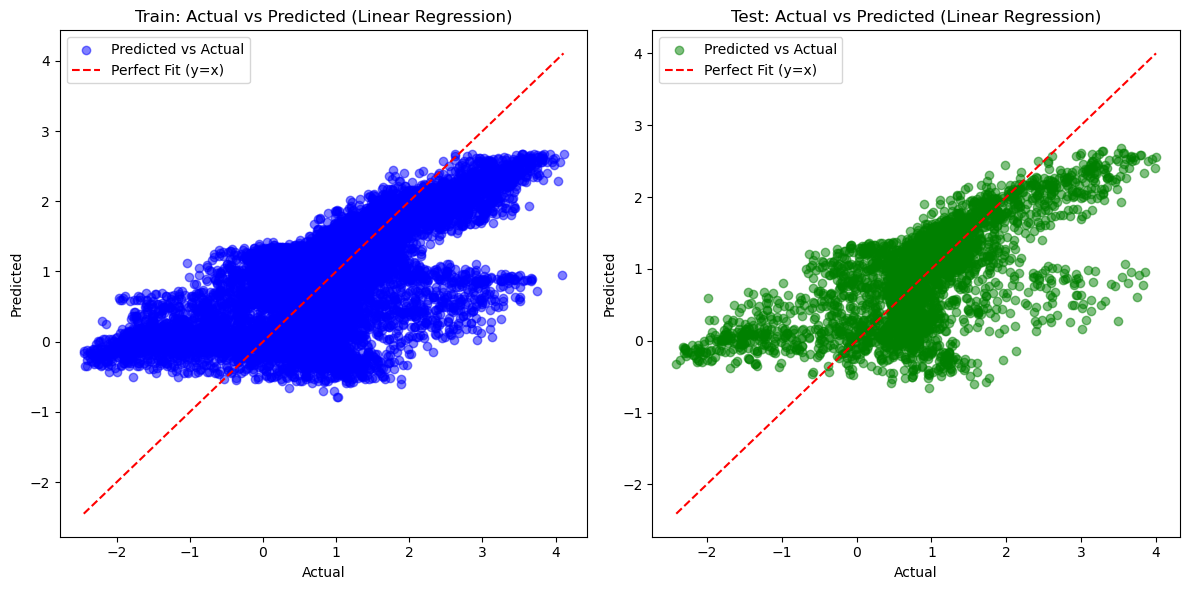

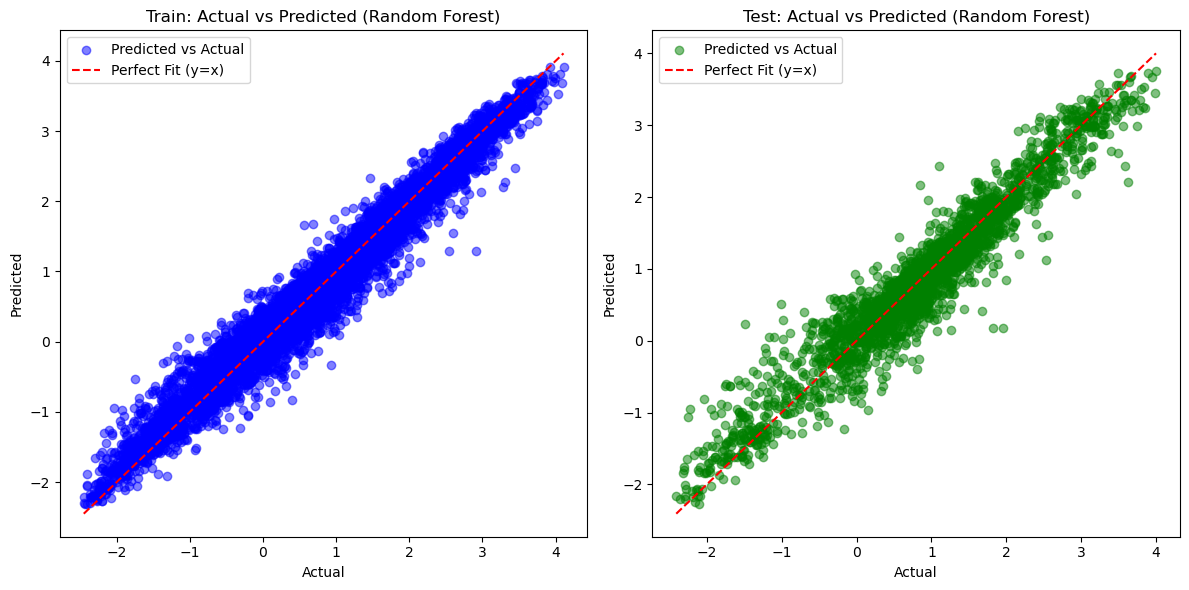

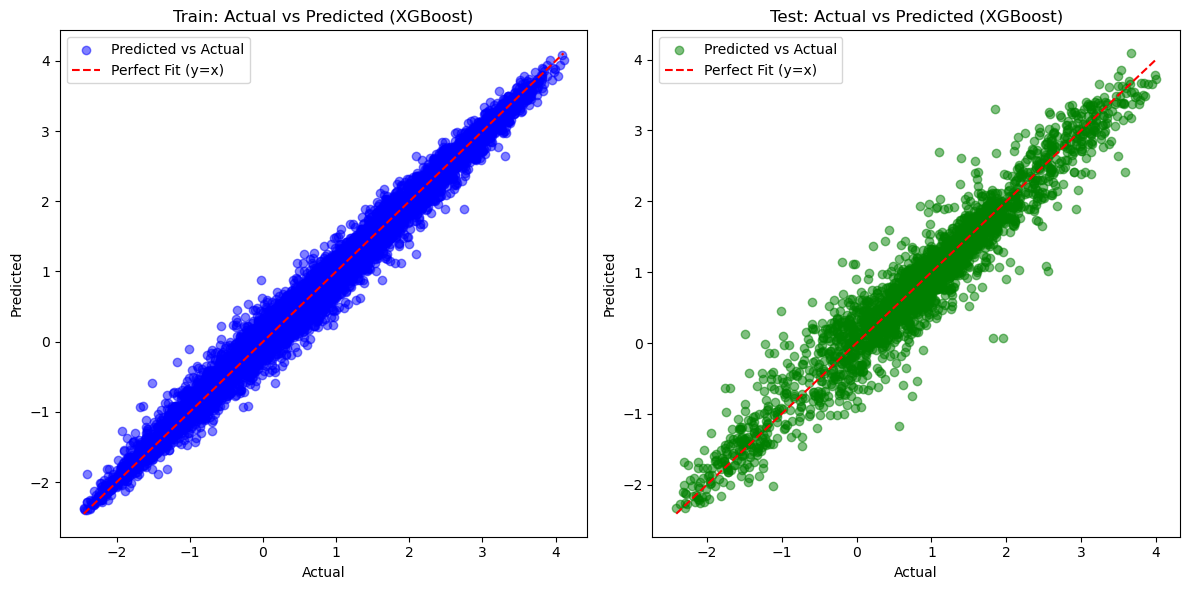

Results for Austin dataset:


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.563242,172.544026,0.442784,0.556213,218.123624,0.436489
1,Random Forest,0.138973,50.985292,0.962831,0.199010,107.049797,0.921312
2,XGBoost,0.098595,37.158369,0.982073,0.194441,130.608788,0.924152



--------------------------------------------------

Evaluating models for NY dataset


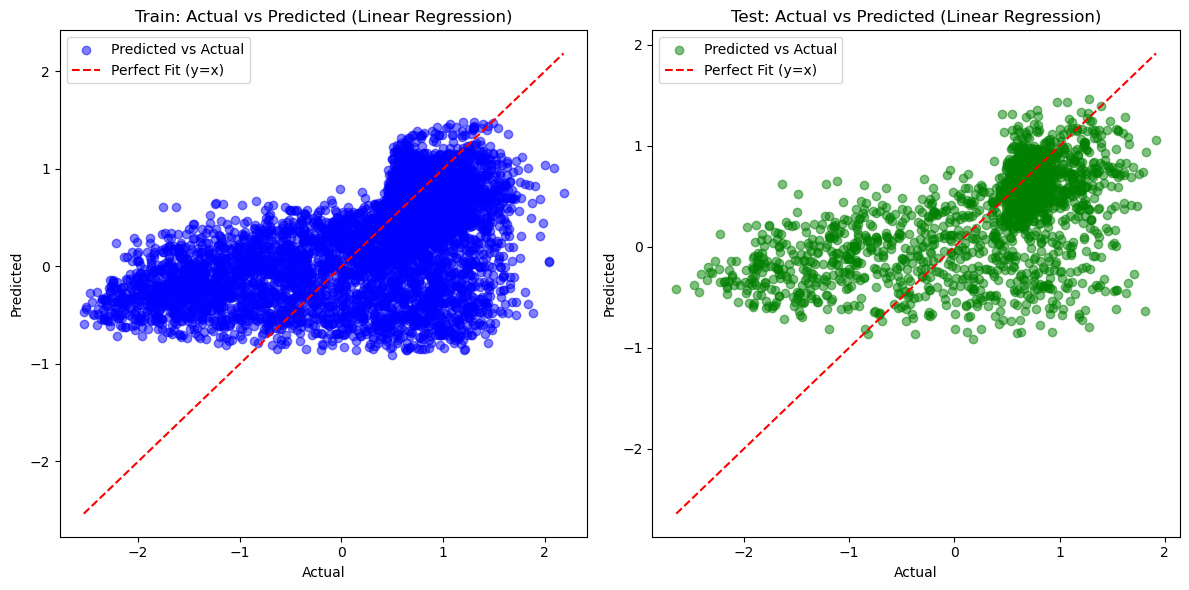

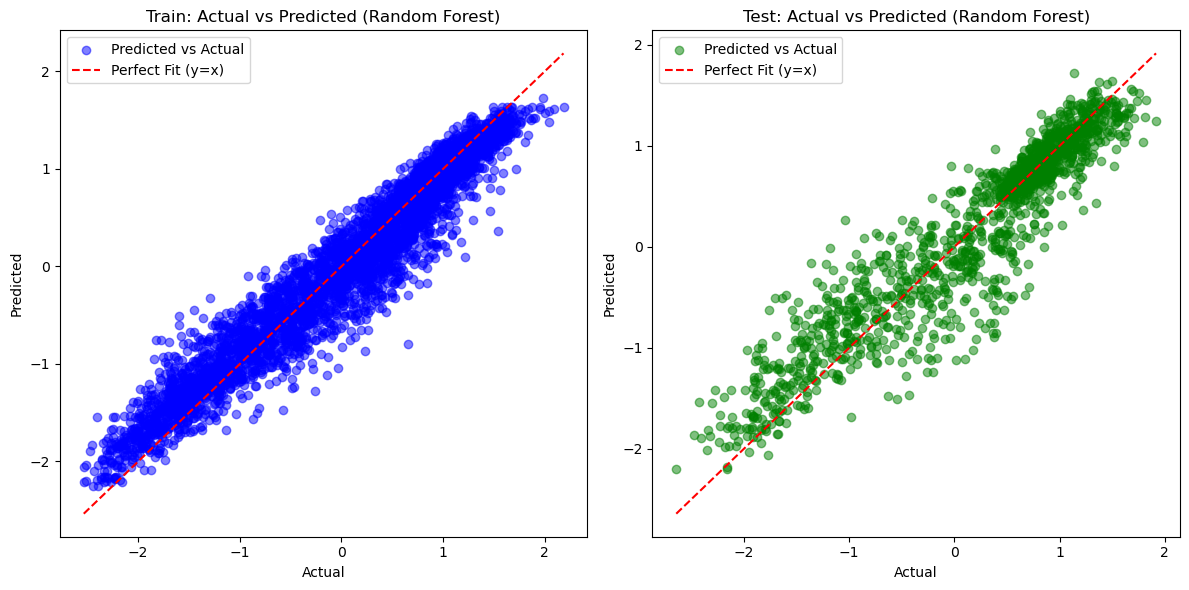

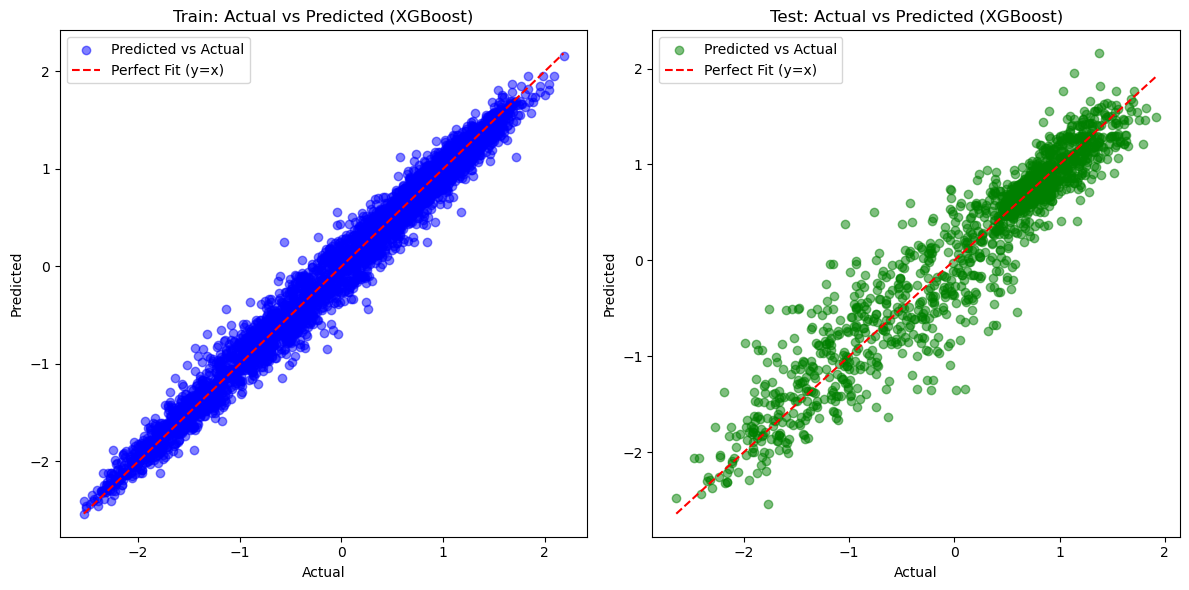

Results for NY dataset:


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.553287,164.966465,0.295772,0.558828,125.368719,0.314457
1,Random Forest,0.148626,128.798480,0.941820,0.216346,81.193712,0.879447
2,XGBoost,0.080740,44.486467,0.983483,0.196105,95.603161,0.902709



--------------------------------------------------



In [16]:
# Define the list of datasets
datasets = {'Austin': df_aus, 'NY': df_ny}  # Add your datasets with descriptive names

# Define feature columns and target
feature_columns = ['month', 'day_name', 'hour', 'season','is_holiday', 'temp', 'rhum', 'wspd']
target = 'grid'

# Loop through each dataset, prepare the data, and evaluate models
for name, df in datasets.items():
    print(f"Evaluating models for {name} dataset")
    
    # Prepare the data
    X_train, y_train, X_test, y_test = prepare_data(df, target_column=target, feature_columns=feature_columns)
    
    # Evaluate models and display the results
    results = evaluate_models(X_train, y_train, X_test, y_test)
    
    # Display results with a title for clarity
    print(f"Results for {name} dataset:")
    display(results)
    print("\n" + "-"*50 + "\n")

### NN

Processing dataset: Austin
Epoch 1/100
435/435 [==============================] - 1s 1ms/step - loss: 0.3640 - mae: 0.4163 - val_loss: 0.1745 - val_mae: 0.2957
Epoch 2/100
435/435 [==============================] - 0s 951us/step - loss: 0.1575 - mae: 0.2870 - val_loss: 0.1256 - val_mae: 0.2593
Epoch 3/100
435/435 [==============================] - 1s 1ms/step - loss: 0.1272 - mae: 0.2590 - val_loss: 0.1248 - val_mae: 0.2531
Epoch 4/100
435/435 [==============================] - 0s 907us/step - loss: 0.1203 - mae: 0.2514 - val_loss: 0.1183 - val_mae: 0.2475
Epoch 5/100
435/435 [==============================] - 0s 904us/step - loss: 0.1122 - mae: 0.2412 - val_loss: 0.1061 - val_mae: 0.2350
Epoch 6/100
435/435 [==============================] - 0s 901us/step - loss: 0.1028 - mae: 0.2303 - val_loss: 0.1040 - val_mae: 0.2296
Epoch 7/100
435/435 [==============================] - 0s 900us/step - loss: 0.1017 - mae: 0.2290 - val_loss: 0.1049 - val_mae: 0.2327
Epoch 8/100
435/435 [===========

,Dataset,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Austin,0.165502,58.616198,0.950502,0.199503,114.907891,0.923378


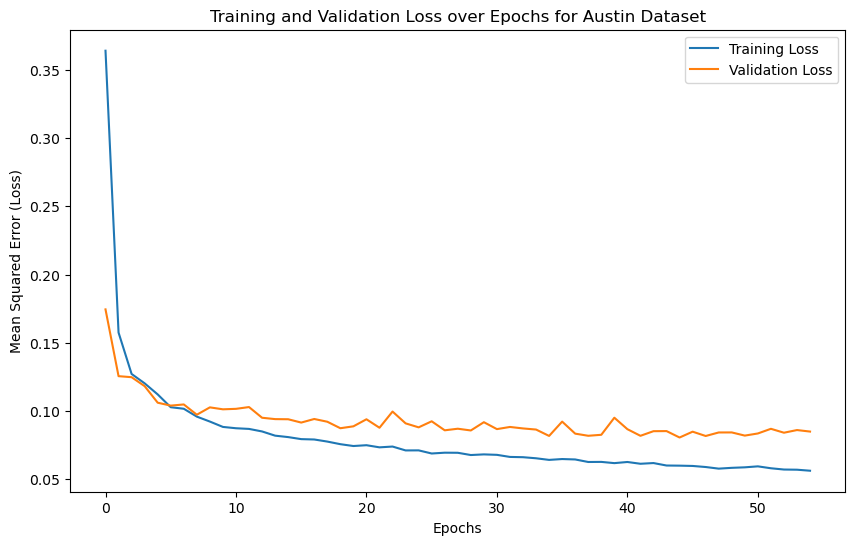

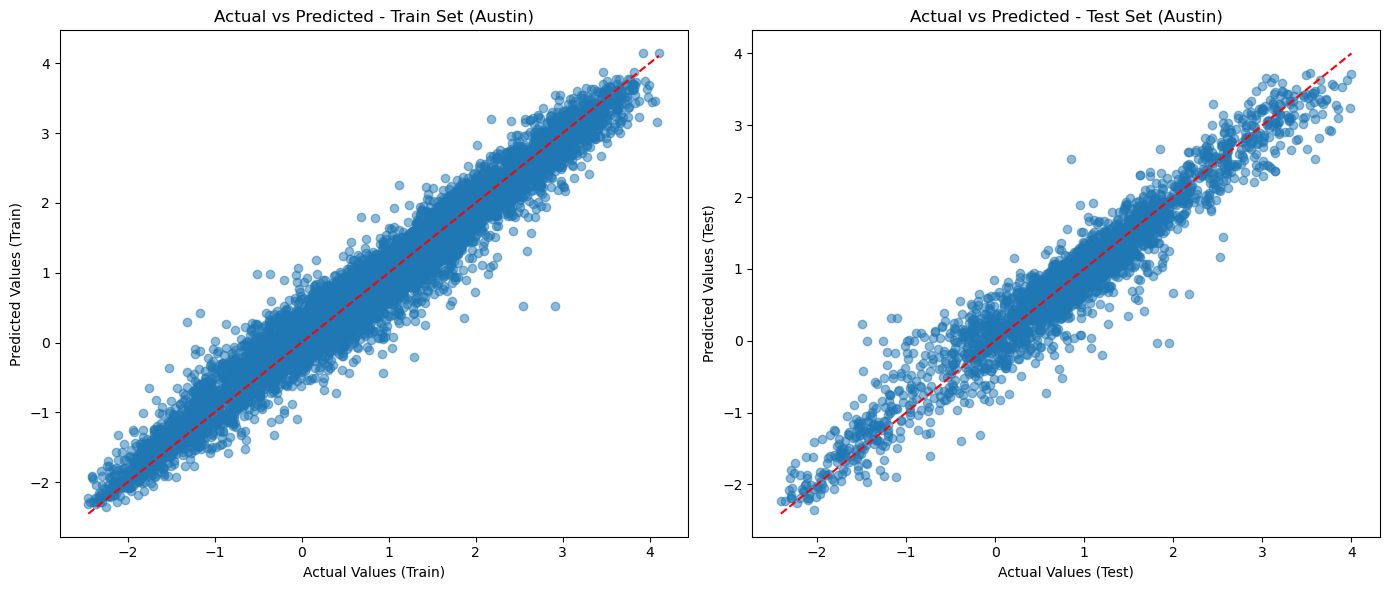

Processing dataset: NY
Epoch 1/100
221/221 [==============================] - 1s 1ms/step - loss: 0.3841 - mae: 0.4438 - val_loss: 0.2397 - val_mae: 0.3569
Epoch 2/100
221/221 [==============================] - 0s 952us/step - loss: 0.2041 - mae: 0.3248 - val_loss: 0.1916 - val_mae: 0.3254
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1732 - mae: 0.2993 - val_loss: 0.1692 - val_mae: 0.2969
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1547 - mae: 0.2826 - val_loss: 0.1552 - val_mae: 0.2862
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1446 - mae: 0.2744 - val_loss: 0.1689 - val_mae: 0.2964
Epoch 6/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1285 - mae: 0.2574 - val_loss: 0.1467 - val_mae: 0.2801
Epoch 7/100
221/221 [==============================] - 0s 949us/step - loss: 0.1253 - mae: 0.2542 - val_loss: 0.1348 - val_mae: 0.2657
Epoch 8/100
221/221 [=====================

,Dataset,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,NY,0.185918,144.010923,0.913866,0.212925,79.617075,0.893568


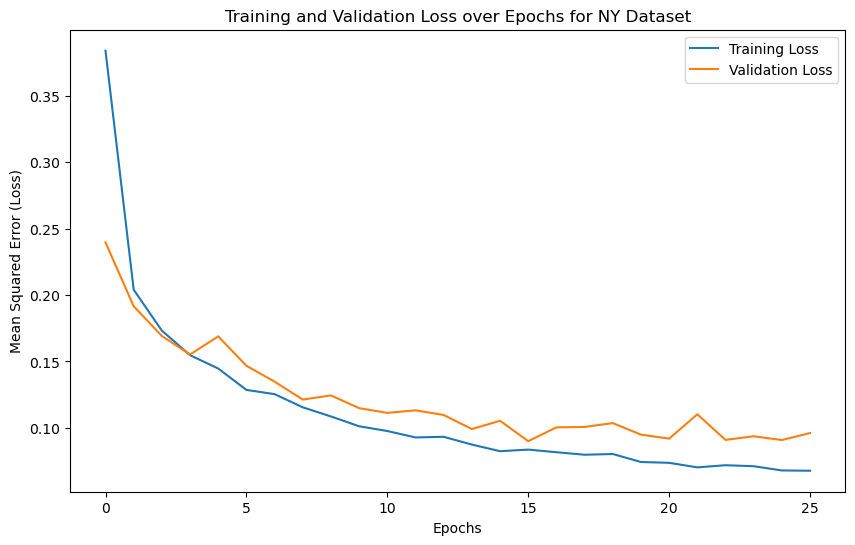

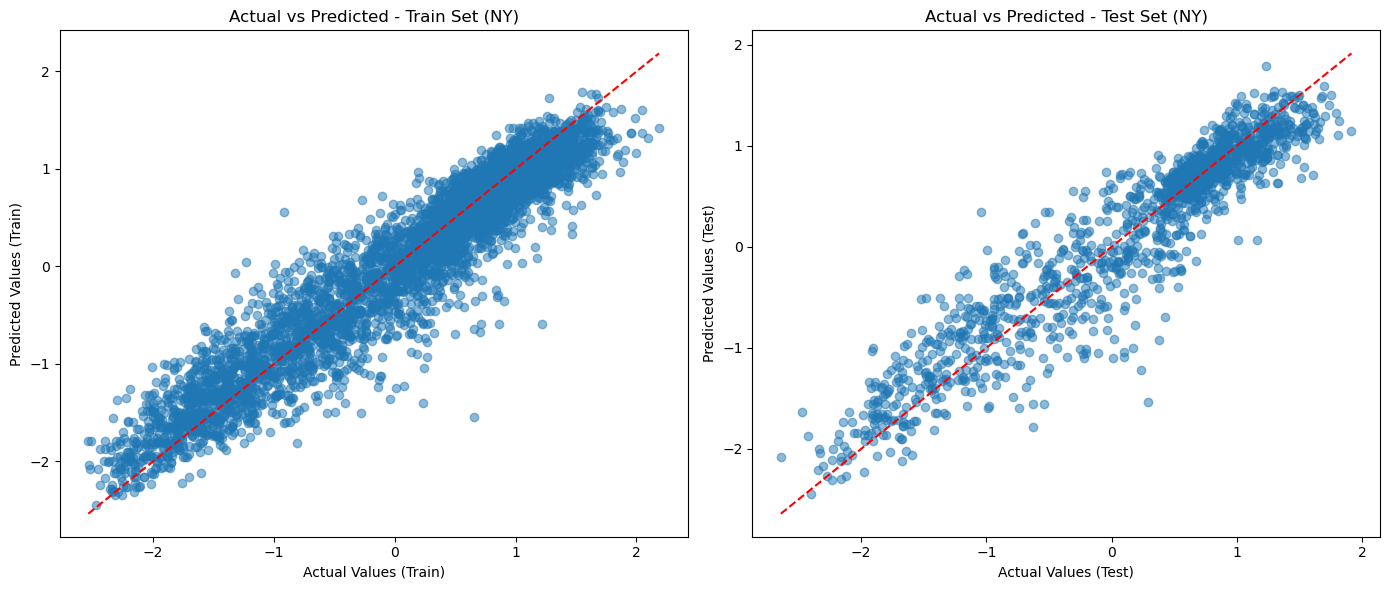

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the list of datasets
datasets = {'Austin': df_aus, 'NY': df_ny}  # Add your datasets with descriptive names

# Define feature columns and target
feature_columns = ['month', 'day_name', 'hour', 'season','is_holiday', 'temp', 'rhum', 'wspd']
target = 'grid'

# Loop through each dataset
for name, df in datasets.items():
    print(f"Processing dataset: {name}")

    # Splitting the data into features (X) and target (y)
    X = df[feature_columns]
    y = df[target]

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing pipeline for feature columns
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(sparse_output=False), categorical_features)
        ]
    )

    # Creating a preprocessing and modeling pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

    # Preprocess the data
    X_train_processed = pipeline.fit_transform(X_train)
    X_test_processed = pipeline.transform(X_test)

    # Ensure y_train and y_test are numpy arrays
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Building the Neural Network model
    model = Sequential([
        Dense(128, input_dim=X_train_processed.shape[1], activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compiling the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Adding early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Training the model
    history = model.fit(X_train_processed, y_train, epochs=100, batch_size=32,
                        validation_data=(X_test_processed, y_test), callbacks=[early_stop])

    # Evaluating the model
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)

    # Calculating metrics with sklearn
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    train_r2 = r2_score(y_train, y_train_pred)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    test_r2 = r2_score(y_test, y_test_pred)

    # Creating a result table
    results = pd.DataFrame({
        'Dataset': [name],
        'Train_MAE': [train_mae],
        'Train_MAPE (%)': [train_mape],
        'Train_R2': [train_r2],
        'Test_MAE': [test_mae],
        'Test_MAPE (%)': [test_mape],
        'Test_R2': [test_r2]
    })

    # Displaying results for the current dataset
    print(f"Results for {name} dataset:")
    display(results)

    # Plotting the loss function over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (Loss)')
    plt.title(f'Training and Validation Loss over Epochs for {name} Dataset')
    plt.legend()
    plt.show()

    # Plotting Actual vs Predicted for Train and Test sets
    plt.figure(figsize=(14, 6))

    # Train set plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel('Actual Values (Train)')
    plt.ylabel('Predicted Values (Train)')
    plt.title(f'Actual vs Predicted - Train Set ({name})')

    # Test set plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values (Test)')
    plt.ylabel('Predicted Values (Test)')
    plt.title(f'Actual vs Predicted - Test Set ({name})')

    plt.tight_layout()
    plt.show()